In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
sys.path.append('/home/manu/TFG_repo/scripts')

In [3]:
from config import data_dir
from analysis_routines import *
from ploting_routines import *
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

## Serie temporal AGL_20181117_chain.nc
El archivo AGL_20181116_chain.nc contiene la serie temporal de los termistores de la cadena instalada en la boya AGL, a partir del 11 de noviembre de 2018 y hasta el 11 de 8 de abril de 2019. Hasta el momento contiene las medidas de 16 termistores, 14 tipo SBE56 y 2 tipo SBE37. **Faltan por introducir las medidas de un termistor SBE16 a la serie**. 

### Datos sin procesar
La serie se ha generado a partir de archivos .mat que contienen la temperatura y la fecha de medida para cada termistor (también la presión para los SBE37). Los SBE56 miden la temperatura del agua cada 5 segundos, y para toda el espectro temporal de la serie, sus fechas están sincronizadas hasta los segundos. El primer, SBE37 situado entorno a 50 metros, tiene un periodo de medida de 10 minutos, mientras que el situado entorno a 225 tiene un periodo de medida de 5 minutos. 

### Formato
El archivo incuye 5 variables y 4 dimensiones. 

Dimensiones:
- **time**: (2471040,) (un valor cada 5 segundos desde el inicio hasta el final de la serie)
- **depth**: (16,)
- **lat**: (1,)
- **lon**: (1,)

Variables:
- **date(time,)**: en formato posix, segundos desde el 1 de enero de 1970 sin cortar segundos intercalares
- **depth(time, depth,)**: en db. 2d con coordenada temporal porque las persiones de los SBE37 las mide el instrumento, y varían ligeramente
- **temp(time, depth,)**: en ºC. 
- **lat(lat,)**: latitud de la boya AGL (mirar unidades)
- **lon(lon,)**: longitud de la boya AGL

Dado que la frecuencia de medida de los SBE56 es mucho más alta que la de los SBE37, se utilizan masked arrays de numpy de tal forma que en los instantes temporales en que no hay medidas de alguno de los SBE37, la presión y temperatura que equivaldrían a dicho termistor no toman ningún valor (mask=True)

### Transformaciones realzadas sobre los datos
- Los archivos para cada termistor incluyen el periodo en el que fueron sacados del agua hasta ser apagados. **La serie ha sido cortada hasta incluir los ultimos puntos antes de que se comenzara a sacar la cadena del agua**.
- El formato de la fecha de los archivos .mat es el propio de matlab datenum. Este formato representa días y su fracción desde el 0 de enero del año 0000 en el calendario gregoriano proléptico. Las librerias de python no trabajan con este formato, por lo que utilizando un script se transforma a tiempo posix o unix, que cuenta segundos desde el 1 de enero de 1970 sin contar segundos intercalares. Para hacer la transformación **se asume que el formato datenum se refiere a tiempo UTC** -> **comprobar que esto es así**
- **La fecha de los SBE56 difiere en un año completo de la de los SBE37** (los SBE56 comienzan en noviembre de 2019 mientras que los SBE37 comienzan en 2018). Se toma como válida la fecha de los SBE37, pues coincide con el título de la carpeta de datos me pasó raquel, AGL_abril_2019 (en abril se saca la cadena del agua) -> **importante revisar y mirar en profundidad esto**
- Si bien todos los SBE56 estan completamente sincronizados hasta los segundos y su periodo de medida es 5 segundos, entre la medida 122 y la 123 sus fechas indican una diferencia de 4 segundos. Para simplificar la sincronización con los SBE37, que están sincronizados en tiempos multiplos de 10 y 5 minutos con segundos a cero, se les añade manualmente un segundo a los SBE56 a partir de la medida 122.


In [4]:
temp, depth, date = load_time_series('unprocessed/AGL_20181116_chain.nc')

In [5]:
print(date[-1])

2019-04-08 11:00:00


#### Plot all thermistors time series to find weird behaviour

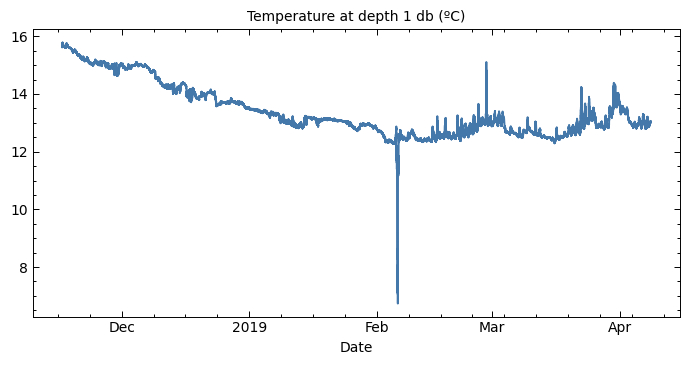

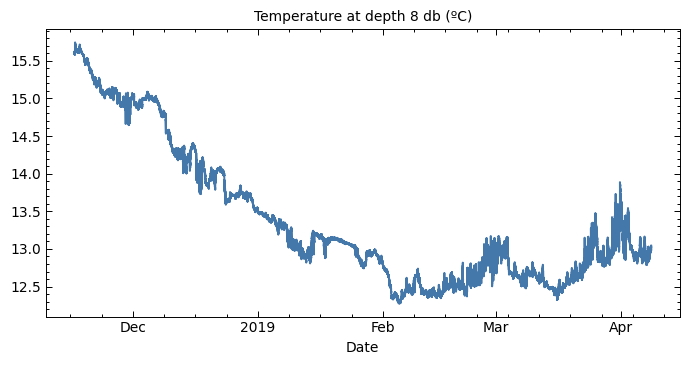

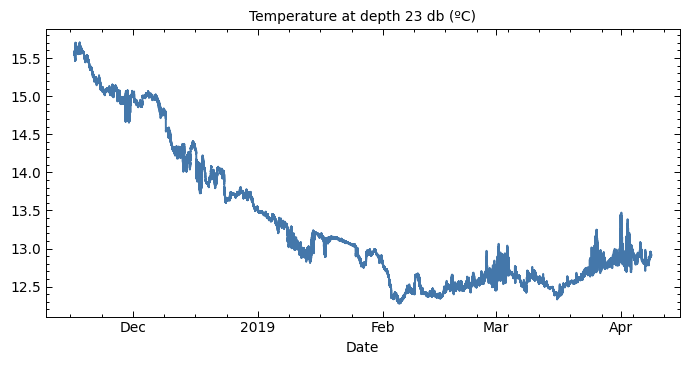

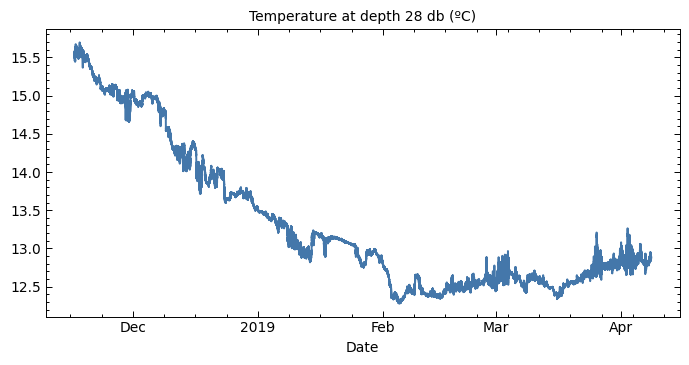

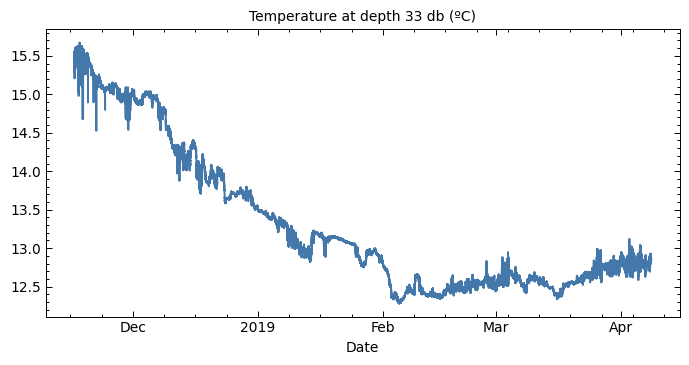

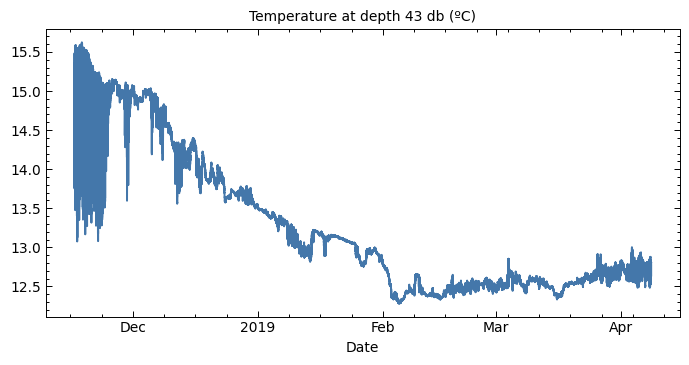

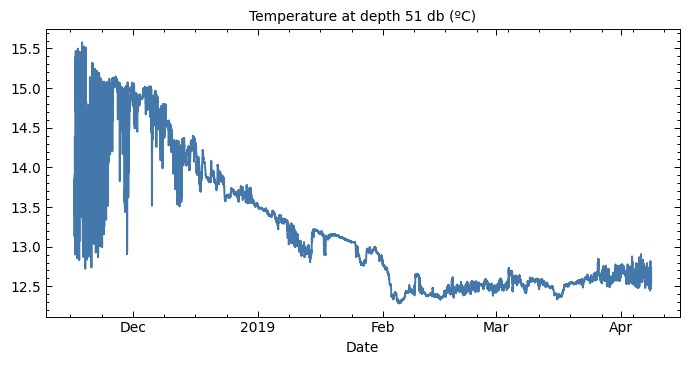

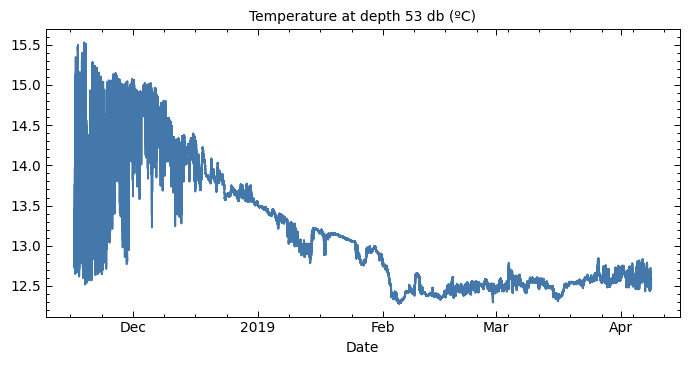

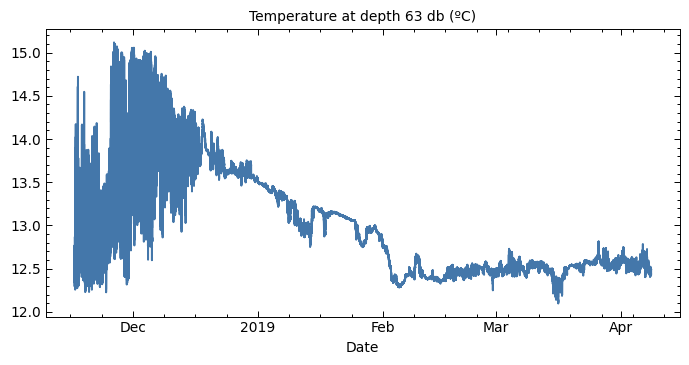

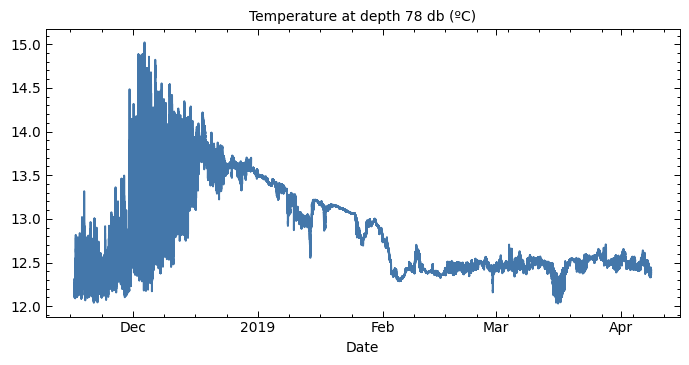

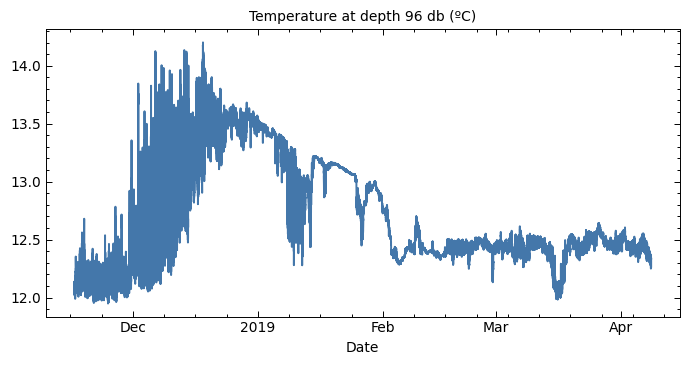

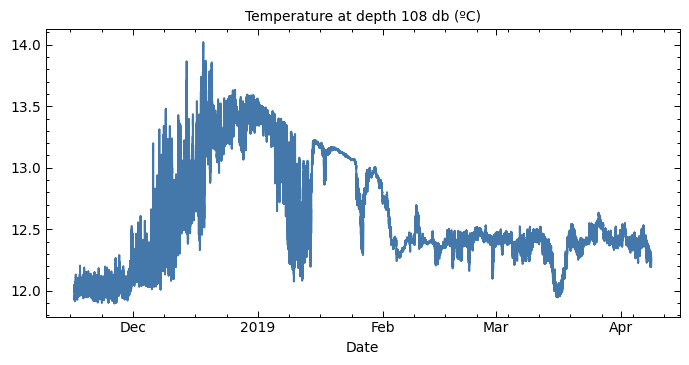

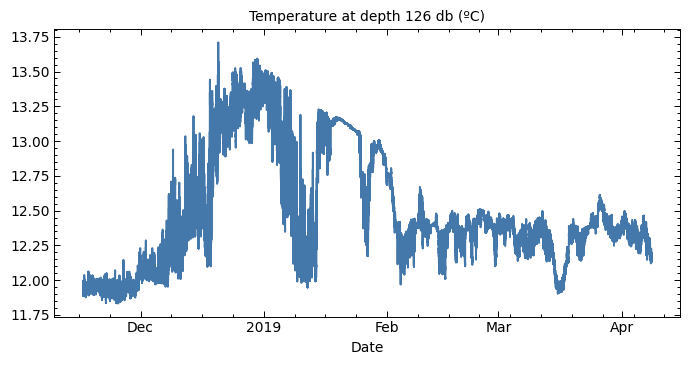

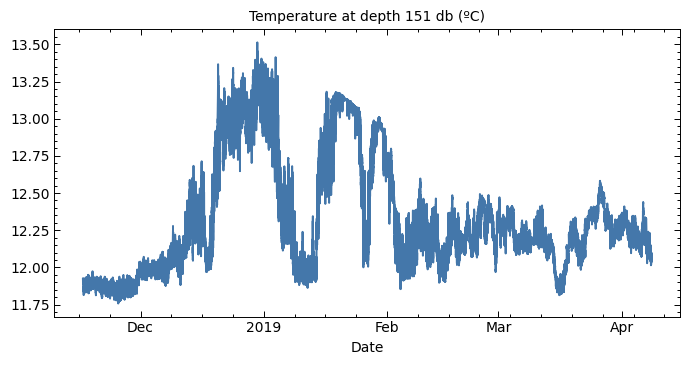

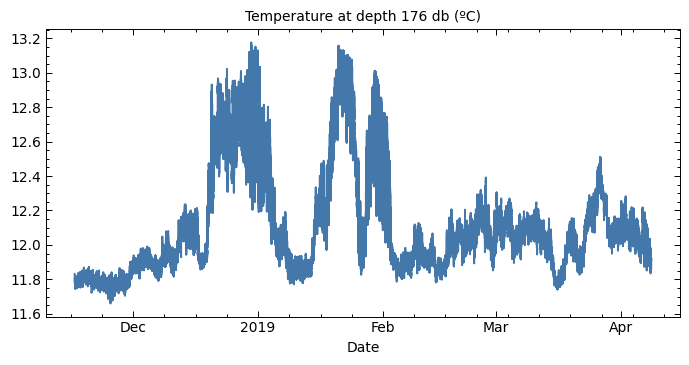

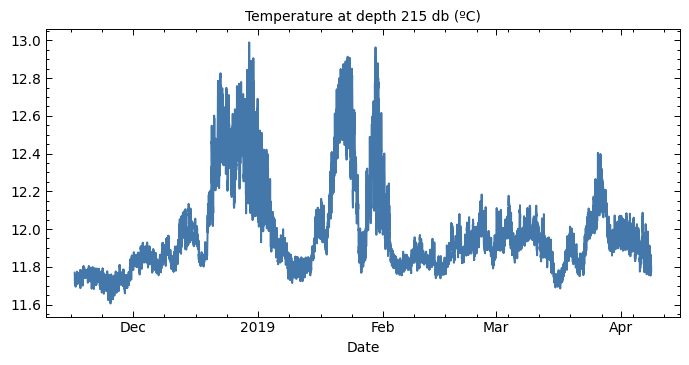

In [25]:
for i in range(depth.shape[1]):
    plot_thermistor_temperature(temp, pres, date, i)

#### Caida de temperatura brusca a principios de febrero en el termistor a 1 db
Se observa una caida fuerte de la temperatura en el termistor a 1db en febrero. Posiblemente se deba al arrastre de la cadena debido al paso de un barco, levantando el primer termistor por encima del agua.

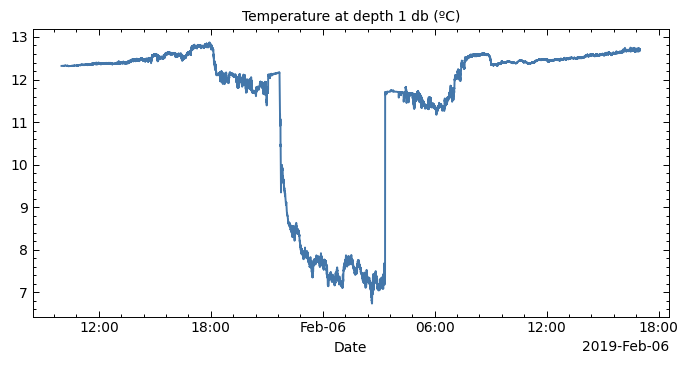

In [31]:
date_1 = datetime(2019, 2, 5, 10)
date_2 = datetime(2019, 2, 6, 17)
plot_thermistor_temperature(temp, pres, date, 0, lims=[date_1, date_2])

De momento se aplicará un mask a este periodo de medidas del primer termistor. Podría asumirse que la temperatura en la superficie apenas cambia y darle un valor a mano. Se podrá explorar más adelante.

In [49]:
iloc_mask_1 = date_to_iloc(date, date_1)
iloc_mask_2 = date_to_iloc(date, date_2)
print(f'Mask a aplicar al primer termistor en temperatura y presión: desde {iloc_mask_1} hasta {iloc_mask_2}')

Mask a aplicar al primer termistor en temperatura y presión: desde 1398240 hasta 1420560


#### Aumento brusco de temperatura a finales de febrero en el termistor a 1db
El salto puede deberse a que, otra vez, el termistor sale del agua por alguna causa. Esta vez es al mediodía por lo que la temperatura es mayor fuera del agua que dentro. Igual que antes, hacer un mask a estos valores.

In [43]:
date_3 = datetime(2019, 2, 27)
date_4 = datetime(2019, 2, 28, 11)

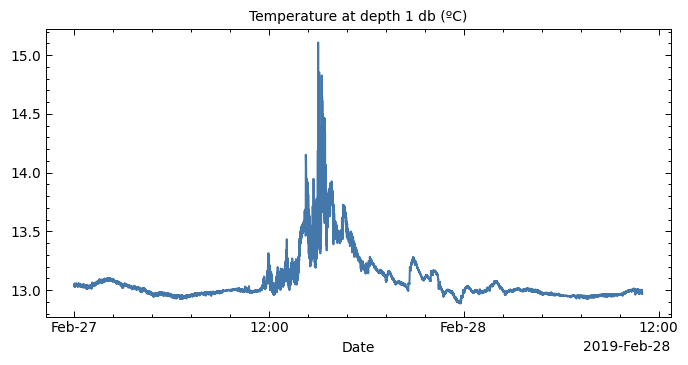

In [44]:
plot_thermistor_temperature(temp, pres, date, 0, lims=[date_3, date_4])

In [48]:
date_3_mask = datetime(2019, 2, 27, 6)
date_4_mask = datetime(2019, 2, 28, 6)
iloc_mask_3 = date_to_iloc(date, date_3_mask)
iloc_mask_4 = date_to_iloc(date, date_4_mask)
print(f'Mask a aplicar al primer termistor en temperatura y presión: desde {iloc_mask_3} hasta {iloc_mask_4}')

Mask a aplicar al primer termistor en temperatura y presión: desde 1775520 hasta 1792800


## Picos de temperatura en superficie a finales de marzo
Es muy probable que estas oscilaciones se deban a algún evento meteoroógico, o ¿al paso de corrientes en superficie? No ignorar de momento. **Comparar con los sensores meteorológicos y de corrientes**.

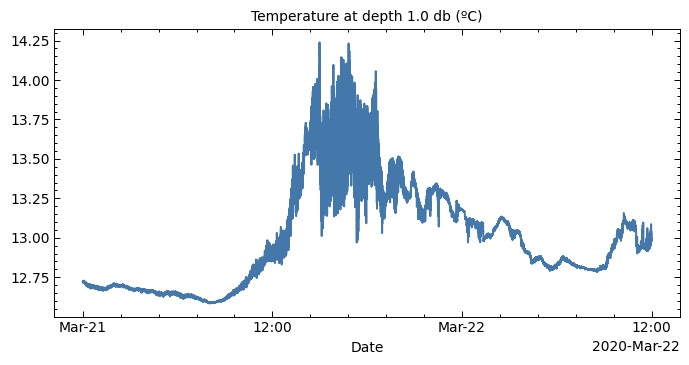

In [126]:
date_5 = datetime(2020, 3, 21)
date_6 = datetime(2020, 3, 22, 12)
plot_thermistor_series(temp, pres, date, 0, lims=[date_5, date_6])

## Pequeños picos en superficie entre febrero y marzo
Son bastante periódicos, y de una ampliud de unos 0.5 grados. No tienen correspondencia en el termistor a 8 db, por lo que tiene que ser un efecto en superficie. ¿Otra vez termistor fuera del agua? ¿O evento meteorológico? Algunos son picos puntuales y otros presentan oscilaciones muy marcadas. Como no son muy signficativos de momento se quedan en la serie, a comprobar con sensores de corrientes y meteorológicos

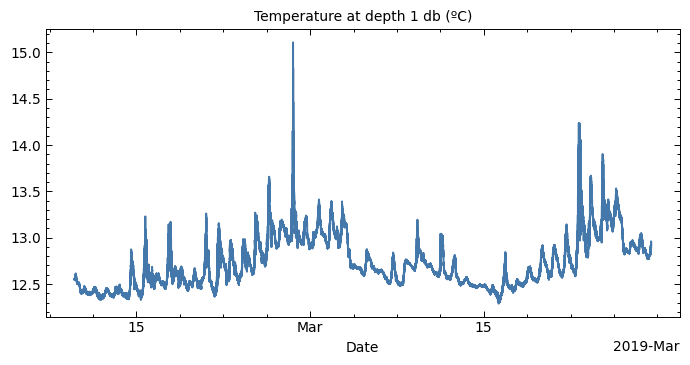

In [12]:
date_5 = datetime(2019, 2, 10)
date_6 = datetime(2019, 3, 28, 12)
plot_thermistor_temperature(temp, depth, date, 0, lims=[date_5, date_6])

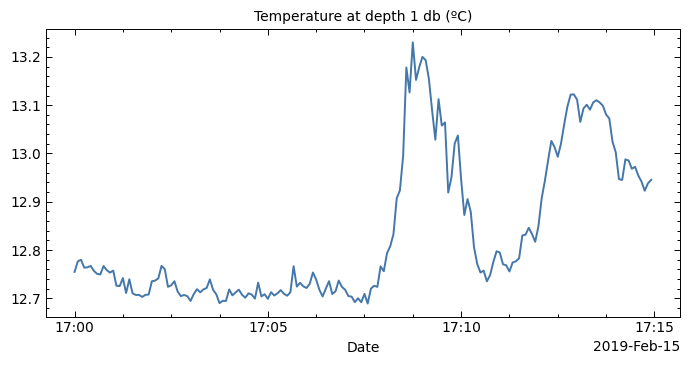

In [22]:
date_7 = datetime(2019, 2, 15, 17)
date_8 = datetime(2019, 2, 15, 17, 15)
plot_thermistor_temperature(temp, depth, date, 0, lims=[date_7, date_8])

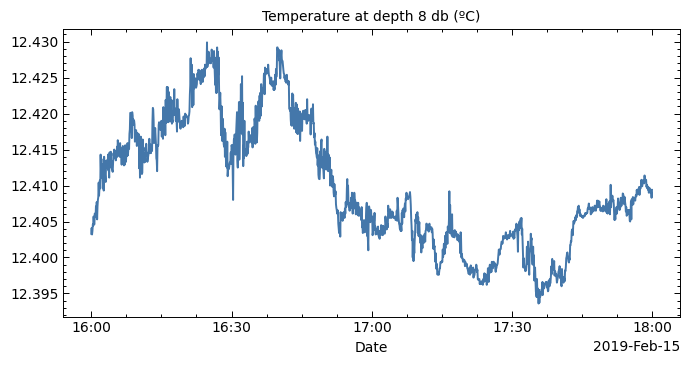

In [18]:
plot_thermistor_temperature(temp, depth, date, 1, lims=[date_7, date_8])

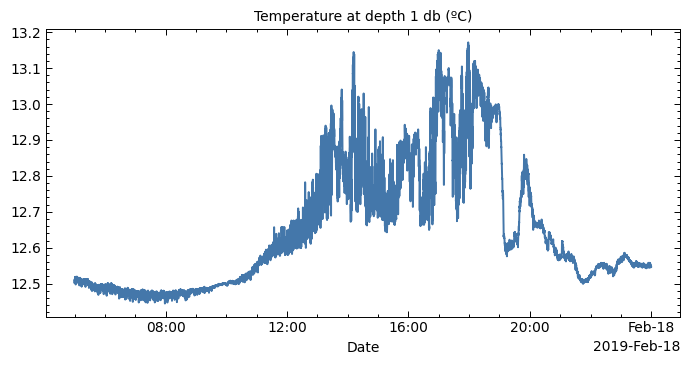

In [30]:
date_9 = datetime(2019, 2, 17, 5)
date_10 = datetime(2019, 2, 18, 0, 0)
plot_thermistor_temperature(temp, depth, date, 0, lims=[date_9, date_10])

## Caida de temperatura en profundidad a finales de febrero
Varios termistores muestran esta caida. ¿Paso de corrientes frías? 

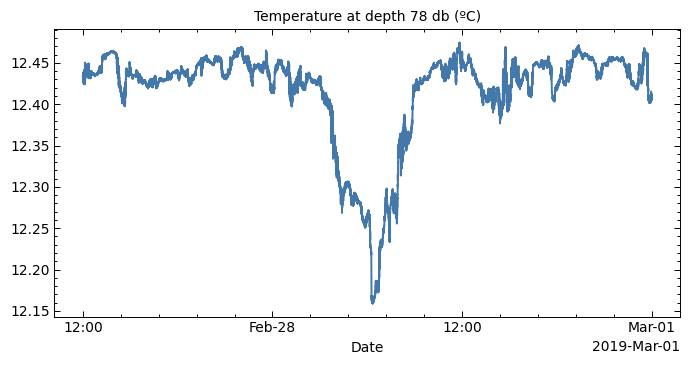

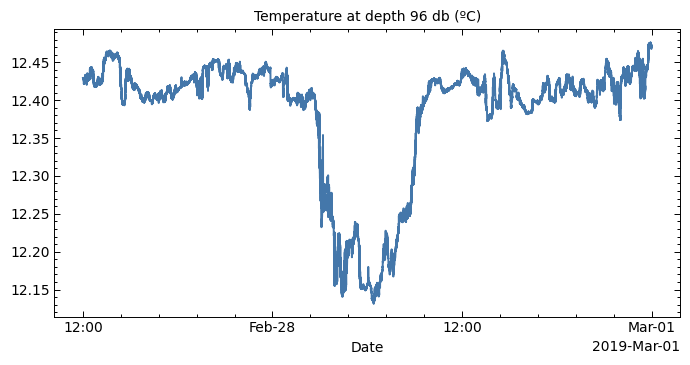

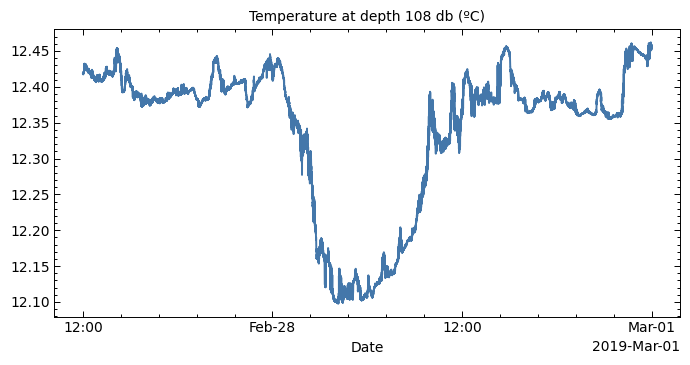

In [45]:
date_11 = datetime(2019, 2, 27, 12)
date_12 = datetime(2019, 3, 1, 0, 0)
plot_thermistor_temperature(temp, depth, date, 9, lims=[date_11, date_12])
plot_thermistor_temperature(temp, depth, date, 10, lims=[date_11, date_12])
plot_thermistor_temperature(temp, depth, date, 11, lims=[date_11, date_12])

In [55]:
temp, depth, date = load_time_series('processed/AGL_20181116_chain.nc')

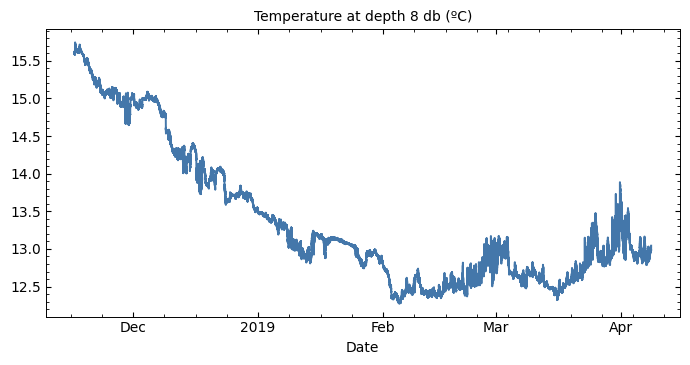

In [11]:
plot_thermistor_temperature(temp, depth, date, 1)